In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


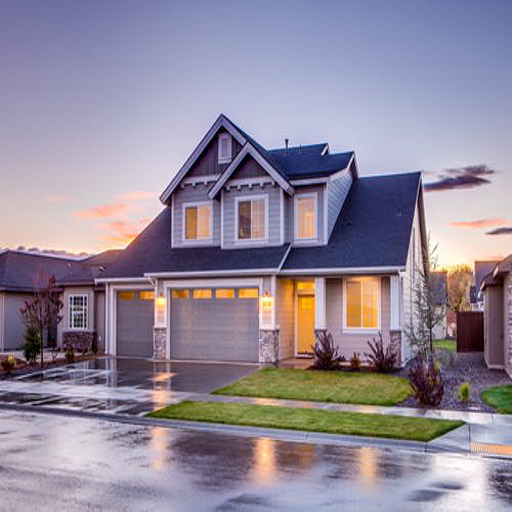

In [2]:
main_image=Image.open('main.png')
main_image=main_image.resize((512,512))

main_image

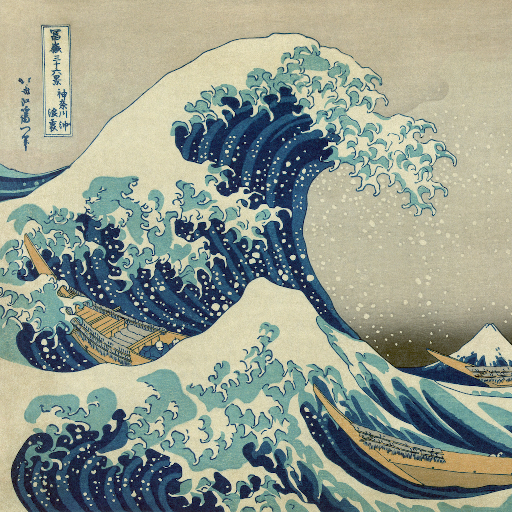

In [3]:
style_image= Image.open('style.png')
style_image=style_image.resize((512,512))

style_image

In [4]:
main_array=np.asarray(main_image,dtype='float32')
main_array=np.expand_dims(main_array,axis=0)
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)

print(main_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [5]:
main_array[:, :, :, 0] -= 103.939
main_array[:, :, :, 1] -= 116.779
main_array[:, :, :, 2] -= 123.68
main_array=main_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]
style_array.shape

(1, 512, 512, 3)

In [6]:
height=512
width=512
main_image=backend.variable(main_array)
style_image=backend.variable(style_array)
final_image=backend.placeholder((1,height,width,3))

input_tensor=backend.concatenate([main_image,style_image,final_image],axis=0)

In [7]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)

main_weight = 0.05
style_weight = 5.0
final_weight = 1.0

layers=dict([(layer.name, layer.output) for layer in model.layers])

loss=backend.variable(0.)

In [8]:
def main_loss(content, combination):
    return backend.sum(backend.square(content-combination))

layer_features=layers['block2_conv2']
main_image_features=layer_features[0,:,:,:]
final_features=layer_features[2,:,:,:]
loss=loss+main_weight*main_loss(main_image_features,final_features)

In [9]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    final_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,final_features)
    loss=loss+(style_weight/len(feature_layers))*sl

In [10]:
def final_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss = loss + final_weight * final_loss(final_image)

grads = backend.gradients(loss, final_image)

outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs = outputs + grads
else:
    outputs.append(grads)
f_outputs = backend.function([final_image], outputs)

In [11]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

Start of iteration - 0
93290130000.0
Iteration 0 done in 20 seconds
Start of iteration - 1
54844846000.0
Iteration 1 done in 13 seconds
Start of iteration - 2
43566256000.0
Iteration 2 done in 14 seconds
Start of iteration - 3
40570917000.0
Iteration 3 done in 14 seconds
Start of iteration - 4
39550180000.0
Iteration 4 done in 14 seconds
Start of iteration - 5
39102650000.0
Iteration 5 done in 14 seconds
Start of iteration - 6
38860770000.0
Iteration 6 done in 14 seconds
Start of iteration - 7
38718490000.0
Iteration 7 done in 14 seconds
Start of iteration - 8
38627734000.0
Iteration 8 done in 14 seconds
Start of iteration - 9
38562402000.0
Iteration 9 done in 14 seconds


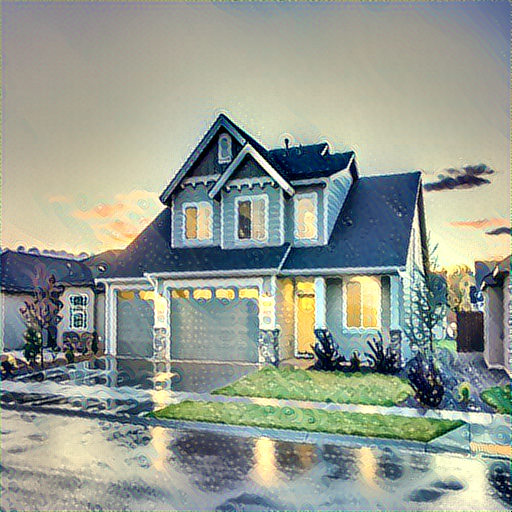

In [12]:
evaluator=Evaluator()

x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 10

import time
for i in range(iterations):
    print('Start of iteration -', i)
    ta = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    tb = time.time()
    print('Iteration %d done in %d seconds' % (i, tb - ta))

print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)